### Importing the required libraries

In [1]:
import pandas as pd
import datetime
import pandas_datareader as pdr
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
start = datetime.datetime(2014, 9, 20)
end = datetime.datetime(2021, 5, 20)

In [3]:
df = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
df.tail()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2021-05-16,43537.511719,43537.511719,46623.558594,42207.289062,46415.898438,7.490364e+10
2021-05-17,42909.402344,42909.402344,45812.457031,42367.832031,43488.058594,5.618737e+10
2021-05-18,37002.441406,37002.441406,43546.117188,30681.496094,42944.976562,1.263581e+11
2021-05-19,40782.738281,40782.738281,42462.984375,35050.617188,36753.667969,8.828194e+10
2021-05-20,37304.691406,37304.691406,42172.171875,33616.453125,40596.949219,8.205162e+10


In [4]:
df.reset_index(inplace=True)
df.columns = df.columns.droplevel(level=1)
df.drop(columns=['Date', 'Adj Close'], inplace=True, axis=1)
df.head(3)

Attributes,Close,High,Low,Open,Volume
0,408.903992,423.295990,389.882996,394.673004,36863600.0
1,398.821014,412.425995,393.181000,408.084991,26580100.0
2,402.152008,406.915985,397.130005,399.100006,24127600.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2432 non-null   float64
 1   High    2432 non-null   float64
 2   Low     2432 non-null   float64
 3   Open    2432 non-null   float64
 4   Volume  2432 non-null   float64
dtypes: float64(5)
memory usage: 95.1 KB


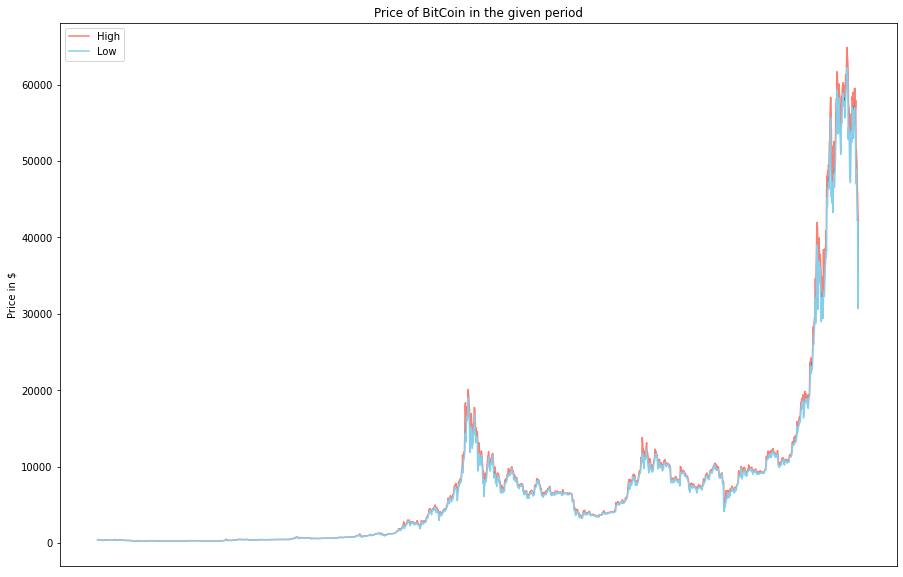

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(df['High'], label='High', color='salmon')
plt.plot(df['Low'], label='Low', color='skyblue')
plt.fill_between(y1=df['Low'], y2=df['High'], x=np.arange(df.shape[0]))
plt.xticks([])
plt.title('Price of BitCoin in the given period')
plt.ylabel('Price in $')
plt.legend()

In [7]:
num_test_data = 7
period = 24
n_data = df.shape[0]

In [8]:
df['index'] = np.arange(df.shape[0])
df.set_index('index', inplace=True)

### Splitting the train and test data

In [9]:
test_data_indices_targets = np.random.choice(np.arange(period, n_data), num_test_data)

In [10]:
test_data_indices = []
for index in test_data_indices_targets:
    test_data_indices.append([item for item in range(index-period, index+1)])
test_data_indices_agg = [item for sub_list in test_data_indices for item in sub_list]

In [11]:
train_data_indices_agg = [index for index in np.arange(n_data) if index not in test_data_indices_agg]

In [12]:
def are_all_days_included(index, train_data_indices_agg):
    for item in range(index-period, index+1):
        if item not in train_data_indices_agg:
            return False
    return True

In [13]:
train_data_indices = []
for index in train_data_indices_agg:
    if index >= period and are_all_days_included(index, train_data_indices_agg):
        train_data_indices.append([item for item in range(index-period, index+1)])

In [14]:
train_data_indices_agg = [item for sub_list in train_data_indices for item in sub_list]

In [15]:
len(train_data_indices), len(test_data_indices)

(2065, 7)

In [16]:
df_train = df.iloc[train_data_indices_agg].drop_duplicates()
df_test = df.iloc[test_data_indices_agg].drop_duplicates()

### Fitting the MinMaxScaler on the training Data

In [17]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
df_train = pd.DataFrame(minMaxScaler.transform(df_train.values), columns=df_train.columns, index=df_train.index)
df_test = pd.DataFrame(minMaxScaler.transform(df_test.values), columns=df_test.columns, index=df_test.index)

In [19]:
# df_train = np.log(df_train)
# df_test = np.log(df_test)

In [20]:
df_train.head(3)

Attributes,Close,High,Low,Open,Volume
index,,,,,
0,0.003645,0.003272,0.003520,0.003438,0.000245
1,0.003485,0.003104,0.003573,0.003650,0.000164
2,0.003538,0.003019,0.003637,0.003508,0.000144


### Making the data ready

In [21]:
y = df_train.pop('Close')
X = df_train.copy()

_y = df_test.pop('Close')
_X = df_test.copy()

### Separating the dataset into periods of 24 days and making the X_dataset and y_dataset

In [22]:
X_train = np.zeros((len(train_data_indices), period, 4))
y_train = np.zeros((len(train_data_indices)))
for index, batch in enumerate(train_data_indices):
    X_train[index] = X.loc[batch[:-1]].values.reshape(period, 4)
    y_train[index] = y.loc[batch[-1]]

In [23]:
X_test = np.zeros((len(test_data_indices), period, 4))
y_test = np.zeros((len(test_data_indices)))
for index, batch in enumerate(test_data_indices):
    X_test[index] = _X.loc[batch[:-1]].values.reshape(period, 4)
    y_test[index] = _y.loc[batch[-1]]

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2065, 24, 4), (2065,), (7, 24, 4), (7,))

### Creating the Data Loaders

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import re
from termcolor import colored
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False, stratify=None)

In [27]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1858, 24, 4), (207, 24, 4), (1858,), (207,))

In [28]:
batch_size = 64

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

train_data = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

val_data = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [29]:
for data, target in train_dataloader:
    print('the shape of the train data tensor: {}'.format(data.shape))
    print('the shape of the train target tensor: {}'.format(target.shape))
    break

the shape of the train data tensor: torch.Size([64, 24, 4])
the shape of the train target tensor: torch.Size([64])


### Utility Functions

In [30]:
def plot_train_test_metric(train_acc, val_acc, xlabel, ylabel, title, metric, ax):
    ax.plot(train_acc, color='salmon', label='train {}'.format(metric), marker='o', linewidth=1)
    ax.annotate(str(np.round(train_acc[-1], 5)), (len(train_acc) - .8, train_acc[-1]), color='salmon')
    ax.plot(val_acc, color='skyblue', label='val {}'.format(metric), marker='o', linewidth=1)
    ax.annotate(str(np.round(val_acc[-1], 5)), (len(val_acc) - .8, val_acc[-1]), color='skyblue')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y')

In [31]:
def inverse_the_outputs(outputs, minMaxScaler):
#     outputs = np.exp(outputs)
    outputs = np.array(outputs.tolist())
    temp = pd.DataFrame({
    'Close': outputs, 
    'High': np.zeros_like(outputs), 
    'Low': np.zeros_like(outputs), 
    'Open': np.zeros_like(outputs), 
    'Volume': np.zeros_like(outputs) 
    })
    outputs = pd.DataFrame(minMaxScaler.inverse_transform(temp.values), columns=temp.columns).Close.values
    return outputs

In [32]:
def plot_actual_vs_predicted(predicted, actuals, ax, title):
    ax.plot(predicted, label='predicted', c='salmon', marker='o', linewidth=1)
    ax.plot(actuals, label='actual', c='skyblue', marker='o', linewidth=1)
    ax.grid(axis='x')
    ax.set_title('Difference betweent the actual price of bitcoin - {}'.format(title))
    ax.legend()

### Model Specification (LSTM)

In [33]:
class Lstm_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(Lstm_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        if self.dropout_rate != None: 
            x = self.dropout(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

In [34]:
lstm_model = Lstm_model(4, [100, 50], 1, None)
output = lstm_model(torch.rand((64, 24, 4)))

### Model Specification (GRU)

In [35]:
class Gru_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(Gru_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.gru = nn.GRU(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        if self.dropout_rate != None: 
            x = self.dropout(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

### Model Specification (RNN)

In [36]:
class RNN_model(nn.Module):
    
    def __init__(self, n_features, hidden_dim, n_output, dropout_rate):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim[0], batch_first=True)
        self.fc1 = nn.Linear(hidden_dim[0], hidden_dim[1])
        if dropout_rate != None:
            self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim[1], n_output)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc1(x[:, -1, :])
        x = nn.ReLU()(x)
        if self.dropout_rate != None:
            x = self.dropout(x)
        x = torch.squeeze(self.fc2(x), 1)
        return x

In [37]:
def initialize_model(model_name, n_features, hidden_dim, n_output, epochs, optimizer_name, dropout_rate):
    if model_name == 'lstm':
        model = Lstm_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'gru': 
        model = Gru_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'rnn': 
        model = RNN_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'mlp':
        model = MLP_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )
    elif model_name == 'gru_extended':
        model = Gru_extended_layers_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )    
    elif model_name == 'cnn_lstm':
        model = CNN_LSTM_model(
            n_features=n_features, 
            hidden_dim=hidden_dim, 
            n_output=n_output,
            dropout_rate=dropout_rate
        )

    # Create the optimizer
    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.001)
    elif optimizer_name== 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'adagrad': 
        optimizer = optim.Adagrad(model.parameters(), lr=0.001)
    
    return model, optimizer

### Training and Evaluating the Model

In [38]:
import random
import time

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, optimizer, val_dataloader, epochs, evaluation):
    """Train the BertClassifier model.
    """

#     val_accuracy_list = []
#     train_accuracy_list = []
    val_loss_list = []
    train_loss_list = []

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

#         train_epoch_accuracy_list = []
        train_epoch_loss_list = []
        
#         print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Elapsed':^9}")
#         print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, (data, targets) in enumerate(train_dataloader):
            batch_counts +=1

            model.zero_grad()

            outputs = model(data.float())

            loss = loss_fn(outputs, targets.float())
            batch_loss += loss.item()
            total_loss += loss.item()

#             preds = torch.argmax(logits, dim=1).flatten()

#             accuracy = (preds == b_labels).cpu().numpy().mean() * 100
#             train_epoch_accuracy_list.append(accuracy)
            train_epoch_loss_list.append(loss.item())


            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
#             scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
#                 print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
#         train_accuracy_list.append(np.mean(train_epoch_accuracy_list))
        train_loss_list.append(np.mean(train_epoch_loss_list))

#         print("-"*70)

        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss = evaluate(model, val_dataloader)
#             val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
#             print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {time_elapsed:^9.2f}")
#             print("-"*70)
#         print("\n")
    
    print("Training complete!")
    return train_loss_list, val_loss_list


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """

    model.eval()


    val_loss = []


    for data, targets in val_dataloader:



        with torch.no_grad():
            outputs = model(data.float())


        loss = loss_fn(outputs, targets.float())
        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)


    return val_loss

In [39]:
import torch.nn.functional as F

def predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_outputs = []

    # For each batch in our test set...
    for data, targets in test_dataloader:

        # Compute logits
        with torch.no_grad():
            outputs = model(data.float())
        all_outputs.append(outputs)
    
    # Concatenate logits from each batch
    all_outputs = torch.cat(all_outputs, dim=0)

    return all_outputs

In [40]:
def test_model(model_name, epochs, hidden_dim, optimizer_name, dropout_rate):
#     loss_fn = loss_function
    set_seed(42)    # Set seed for reproducibility
    
    model, optimizer = initialize_model(
        model_name=model_name, 
        n_features = 4, 
        hidden_dim = hidden_dim, 
        n_output = 1,
        epochs=epochs,
        optimizer_name=optimizer_name, 
        dropout_rate=dropout_rate
    )
    
    start_time = time.time()
    
    train_loss_list, val_loss_list = train(
        model=model,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        val_dataloader=val_dataloader,
        epochs=epochs,
        evaluation=True
    )
    
    end_time = time.time()
    print('time elapsed: {}'.format(end_time - start_time))
    print('the best loss on validation data: {}'.format(val_loss_list[-1]))
    
#     loss plots

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_train_test_metric(train_loss_list, val_loss_list, "epochs", "loss", "{} - loss for different epochs".format(model_name), "loss", ax=axs[0, 0])
    
    
#     val

    outputs = predict(model, val_dataloader)
    outputs_inversed = inverse_the_outputs(outputs, minMaxScaler)
    plot_actual_vs_predicted(outputs_inversed, y_val_inversed, axs[0, 1], 'validation')
    
    
#     test
    
    outputs = predict(model, test_dataloader)
    outputs_inversed = inverse_the_outputs(outputs, minMaxScaler)
    plot_actual_vs_predicted(outputs_inversed, y_test_inversed, axs[1, 0], 'test')
    print('loss on the test data before the inversion of the transforms applied: {}'.format(evaluate(model, test_dataloader)))
    print('actual rmse loss after inversion of the transforms applied: {}'.format(mean_squared_error(y_test_inversed, outputs_inversed, squared=False)))
    print('actual mae loss after inversion of the transforms applied: {}'.format(mean_absolute_error(y_test_inversed, outputs_inversed)))
    axs[1, 1].axis("off")
    fig.tight_layout()

In [41]:
epochs = 50
hidden_dim = [100, 50]

In [42]:
y_val_inversed = inverse_the_outputs(y_val, minMaxScaler)
y_test_inversed = inverse_the_outputs(y_test, minMaxScaler)

Start training...

Training complete!
time elapsed: 24.916420936584473
the best loss on validation data: 0.004389647998323198
loss on the test data before the inversion of the transforms applied: 0.003454329678788781
actual rmse loss after inversion of the transforms applied: 3721.8552026487464
actual mae loss after inversion of the transforms applied: 1503.4819530585867


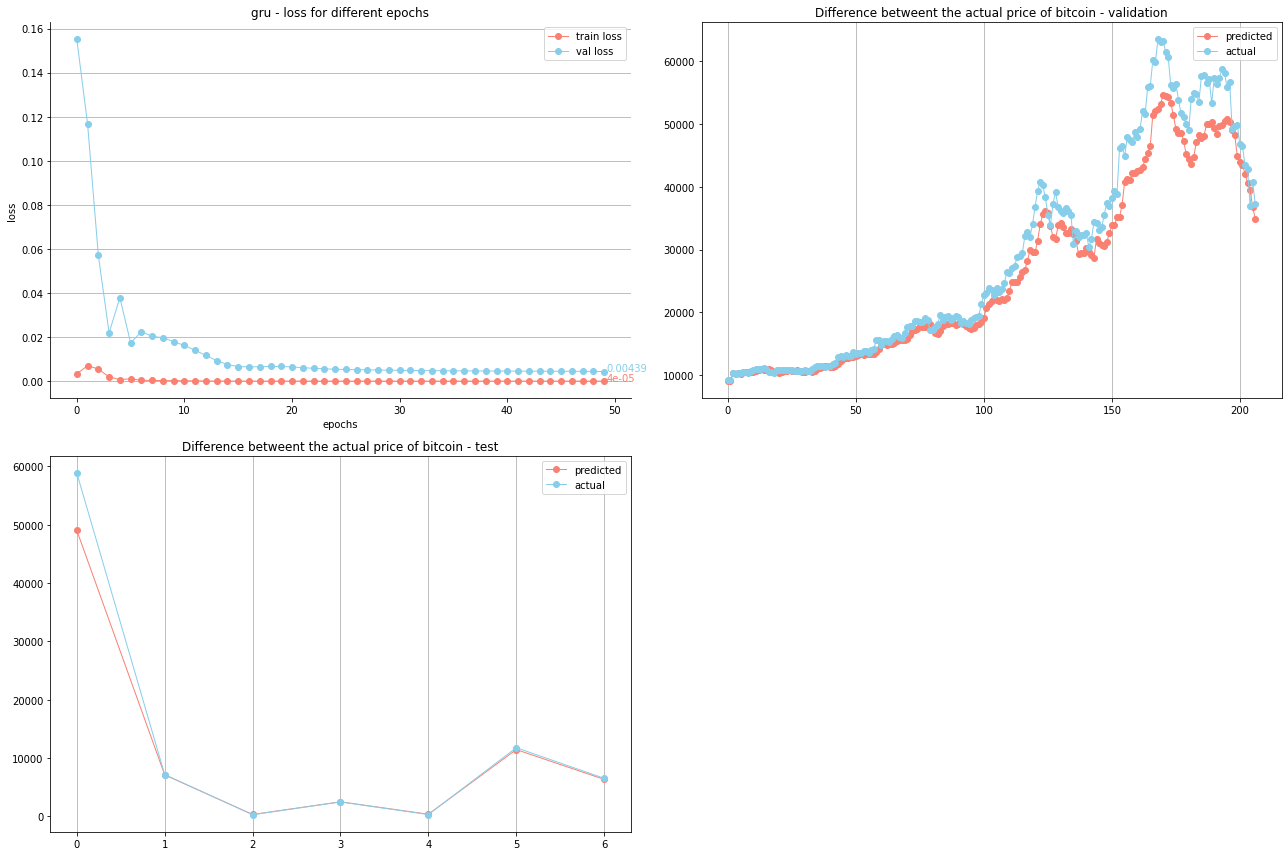

In [43]:
loss_fn = nn.MSELoss()
test_model(
    model_name='gru',
    epochs=epochs, 
    hidden_dim=hidden_dim, 
    optimizer_name='adam', 
    dropout_rate=None
)